Write a program for the Implementation of a Generative Adversarial
Network for generating synthetic shapes (like digits)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1 completed.


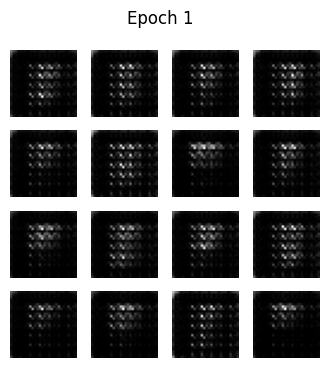

Epoch 2 completed.


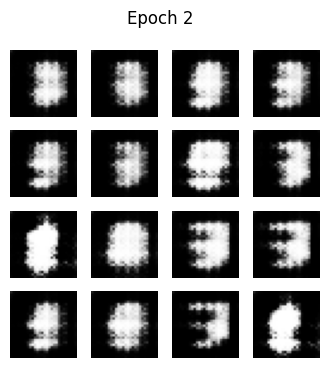

Epoch 3 completed.


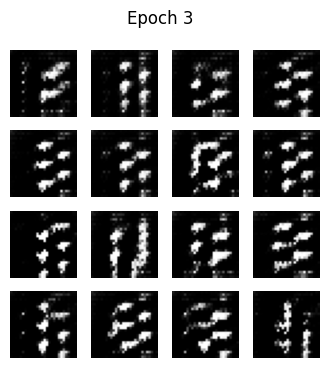

Epoch 4 completed.


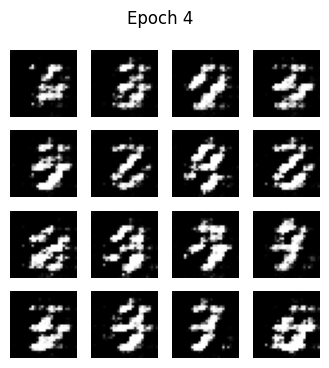

Epoch 5 completed.


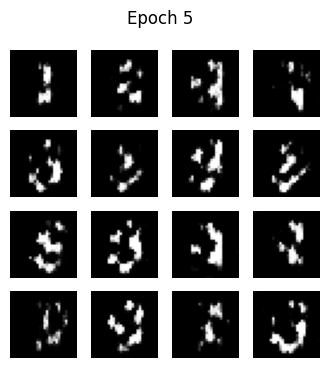

Epoch 6 completed.


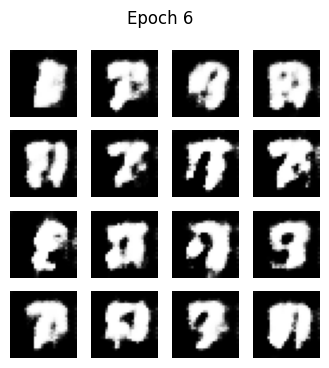

Epoch 7 completed.


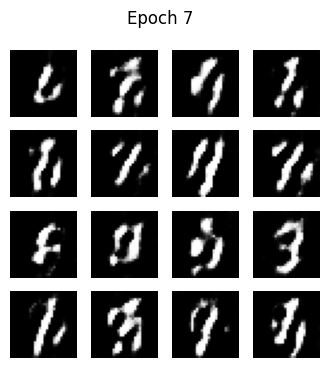

Epoch 8 completed.


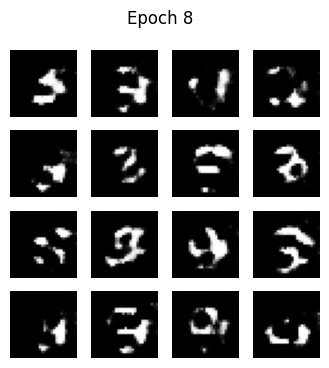

Epoch 9 completed.


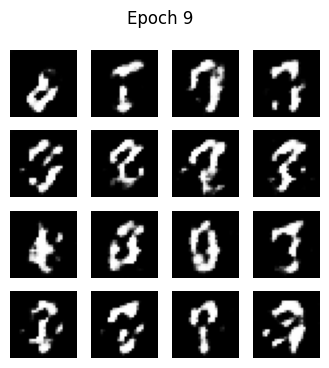

Epoch 10 completed.


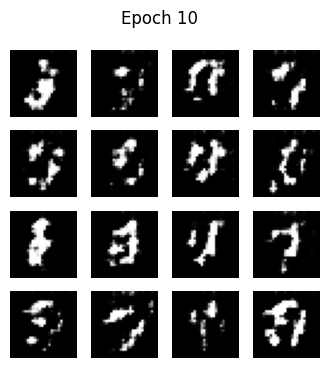

Epoch 11 completed.


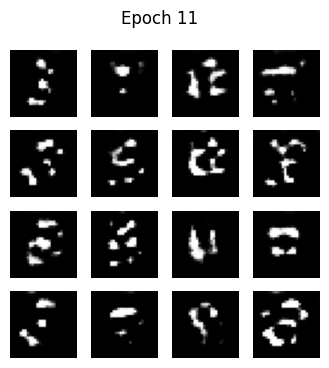

Epoch 12 completed.


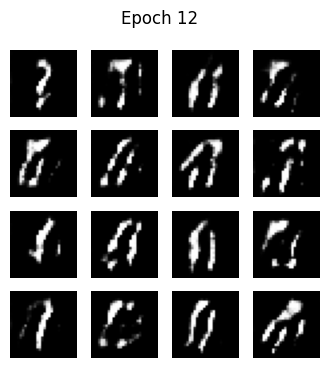

Epoch 13 completed.


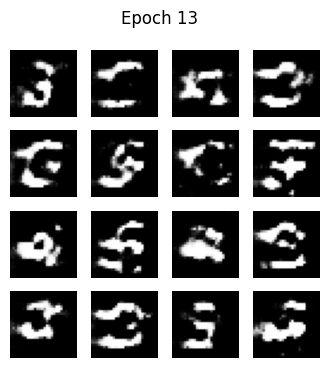

Epoch 14 completed.


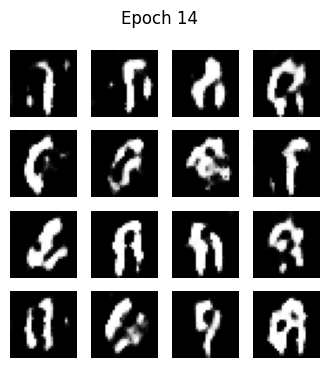

Epoch 15 completed.


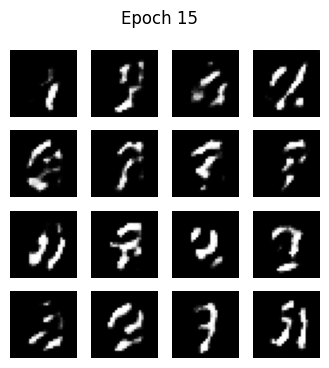

Epoch 16 completed.


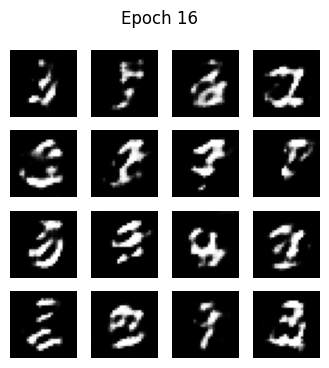

Epoch 17 completed.


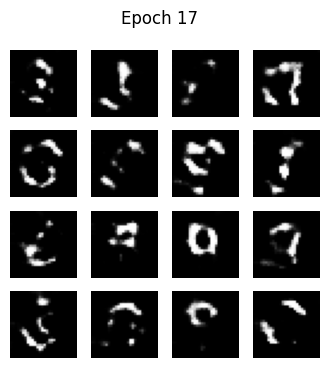

Epoch 18 completed.


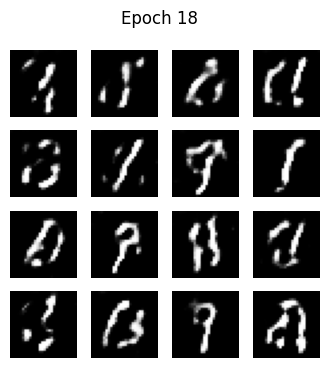

Epoch 19 completed.


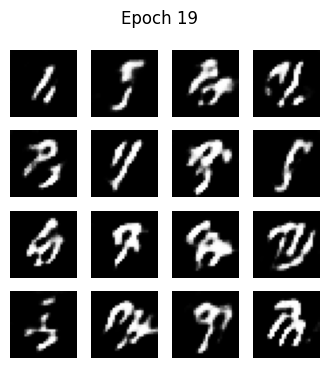

Epoch 20 completed.


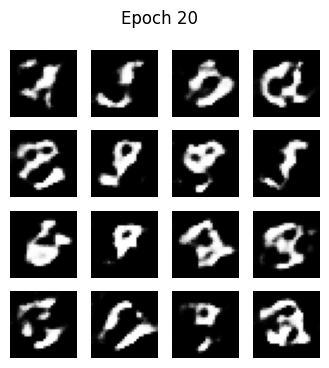

Epoch 21 completed.


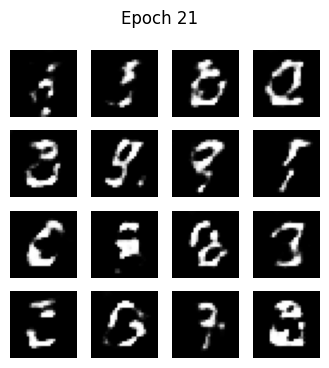

Epoch 22 completed.


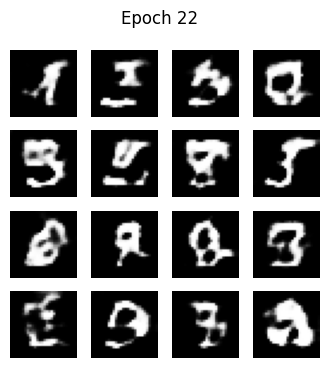

Epoch 23 completed.


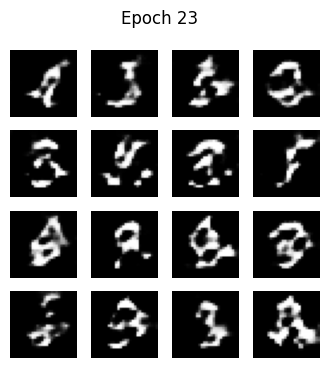

Epoch 24 completed.


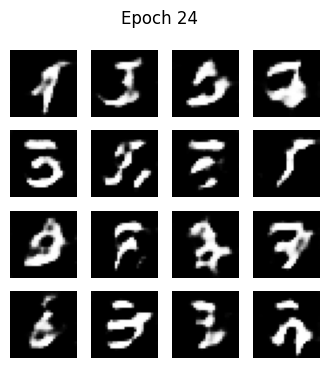

Epoch 25 completed.


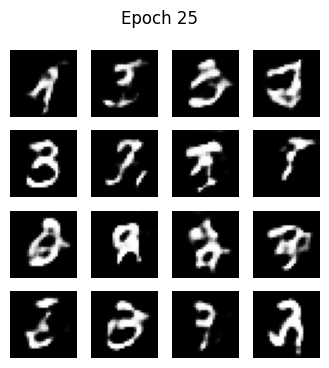

Epoch 26 completed.


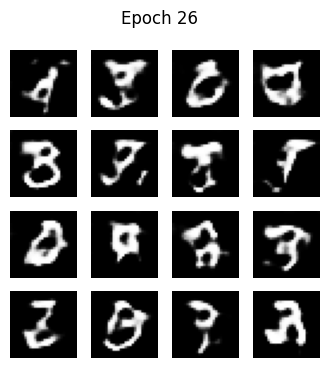

Epoch 27 completed.


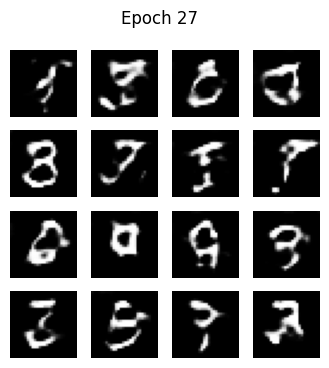

Epoch 28 completed.


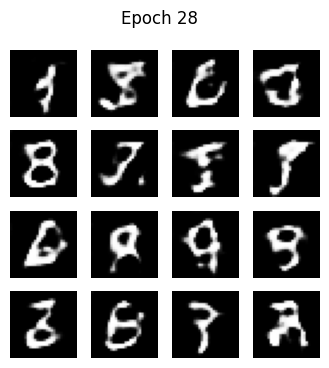

Epoch 29 completed.


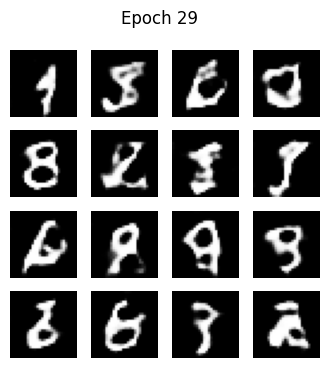

Epoch 30 completed.


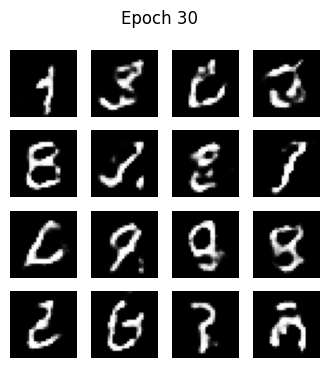

Epoch 31 completed.


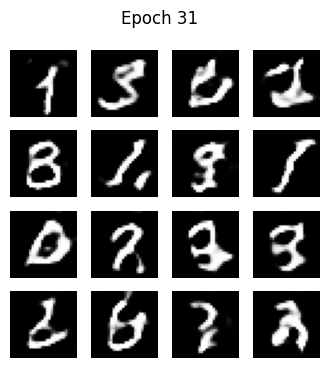

Epoch 32 completed.


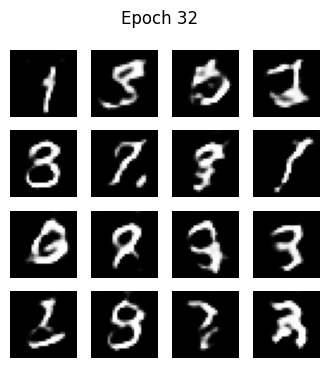

Epoch 33 completed.


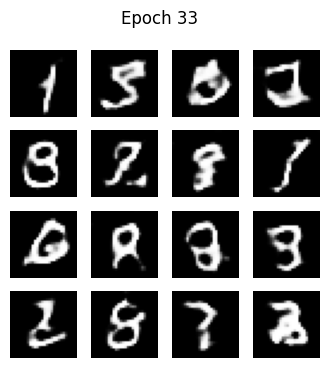

Epoch 34 completed.


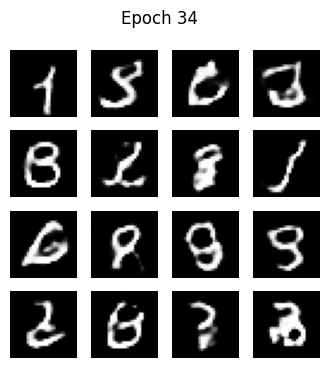

Epoch 35 completed.


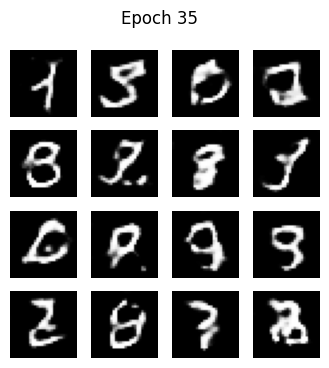

Epoch 36 completed.


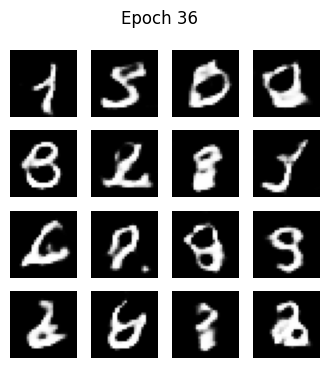

Epoch 37 completed.


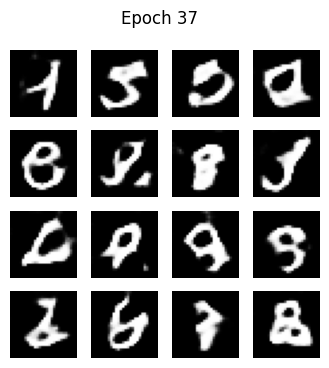

Epoch 38 completed.


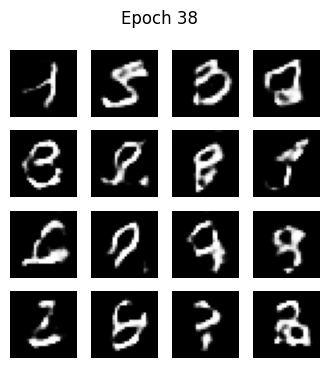

Epoch 39 completed.


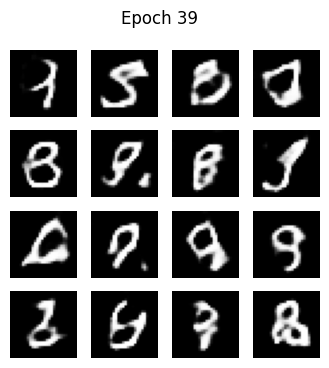

Epoch 40 completed.


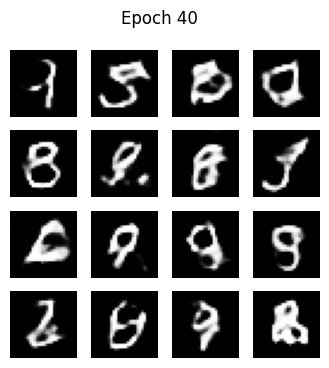

Epoch 41 completed.


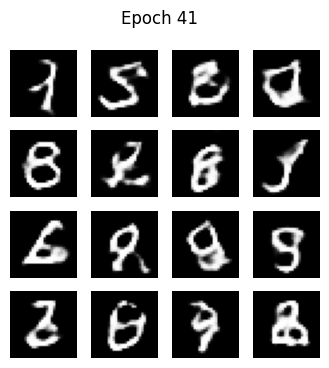

Epoch 42 completed.


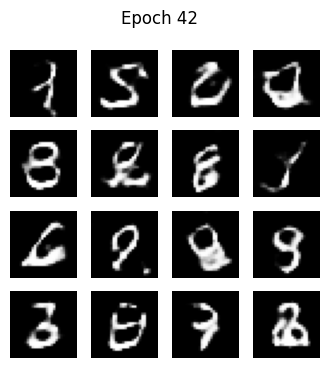

Epoch 43 completed.


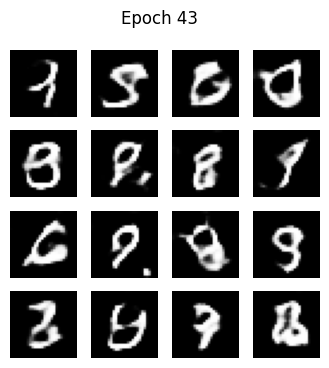

Epoch 44 completed.


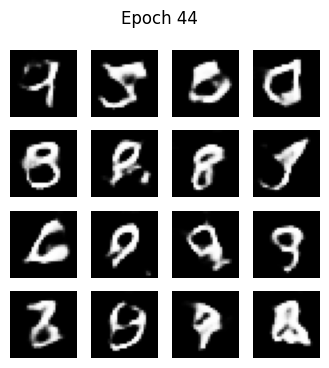

Epoch 45 completed.


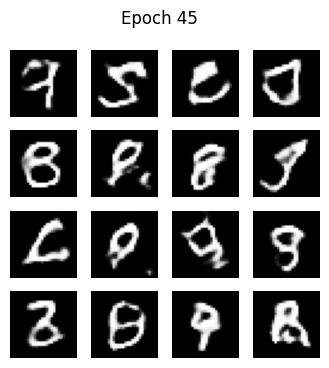

Epoch 46 completed.


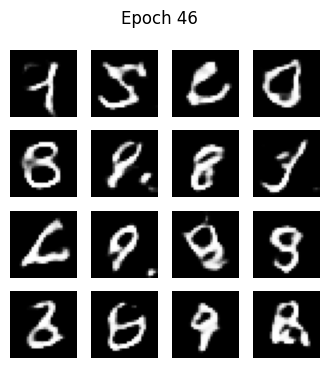

Epoch 47 completed.


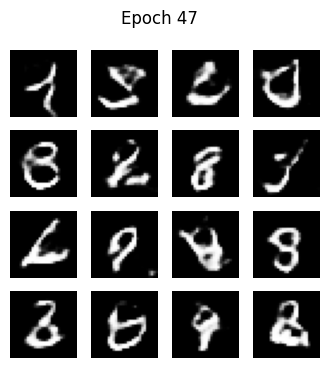

Epoch 48 completed.


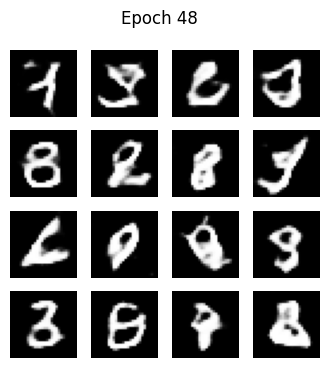

Epoch 49 completed.


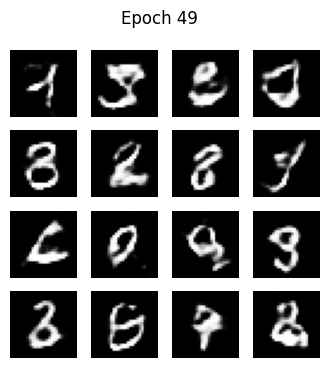

Epoch 50 completed.


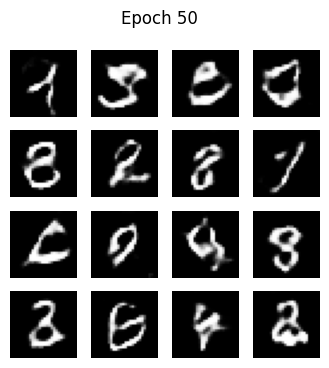

In [3]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

# 1. Load and preprocess MNIST data
(x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 127.5 - 1  # normalize to [-1, 1]
x_train = x_train.reshape(-1, 28, 28, 1)

BUFFER_SIZE = 60000
BATCH_SIZE = 256
EPOCHS = 50
NOISE_DIM = 100

# Create dataset
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# 2. Build the Generator
def build_generator():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(NOISE_DIM,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    model.add(layers.Conv2DTranspose(128, (5,5), strides=(1,1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', use_bias=False, activation='tanh'))

    return model

# 3. Build the Discriminator
def build_discriminator():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

# 4. Losses and optimizers
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator = build_generator()
discriminator = build_discriminator()

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# 5. Training loop
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_gen = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_disc = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_gen, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_disc, discriminator.trainable_variables))

# 6. Generate and plot images
def generate_and_plot_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))
    for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0]*127.5 + 127.5, cmap='gray')
        plt.axis('off')
    plt.suptitle(f"Epoch {epoch}")
    plt.show()

# 7. Training function
seed = tf.random.normal([16, NOISE_DIM])

def train(dataset, epochs):
    for epoch in range(1, epochs+1):
        for image_batch in dataset:
            train_step(image_batch)

        print(f"Epoch {epoch} completed.")
        generate_and_plot_images(generator, epoch, seed)

# 8. Start training
train(train_dataset, EPOCHS)
